<a href="https://colab.research.google.com/github/skywalker0803r/Ricky/blob/master/%E7%8E%89%E5%B1%B1AI%E6%AF%94%E8%B3%BD_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
from google.colab import drive
drive.mount('/content/drive')
import warnings 
warnings.simplefilter('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
中文map = {'bacno':'歸戶帳號','txkey':'交易序號','locdt':'授權日期','loctm':'授權時間','cano':'交易卡號',
         'contp':'交易類別','etymd':'交易型態','mchno':'特店代號','acqic':'收單行代碼','mcc':'MCC_CODE',
         'conam':'交易金額-台幣(經過轉換)','ecfg':'網路交易註記','insfg':'分期交易註記','iterm':'分期期數',
         'stocn':'消費地國別','scity':'消費城市','stscd':'狀態碼','ovrlt':'超額註記碼','flbmk':'Fallback註記',
         'hcefg':'支付型態','csmcu':'消費地幣別','flg_3dsmk':'3DS交易註記','fraud_ind':'盜刷註記'}

# train

In [38]:
import pandas as pd
train = pd.read_csv("/content/drive/My Drive/玉山人工智慧比賽數據/train_特徵工程完.csv",index_col=0)
print(train.shape)
train.head()

(1521787, 72)


,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,hcefg,insfg,iterm,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,acqic_stscd_2_norm_count,acqic_stscd_0_norm_count,cano_stscd_2_norm_count,cano_stscd_0_norm_count,bacno_stscd_2_norm_count,bacno_stscd_0_norm_count,cano_stscd_nunique,acqic_etymd_8_norm_count,acqic_hcefg_nunique,bacno_stscd_nunique,acqic_ovrlt_0_norm_count,acqic_ovrlt_1_norm_count,acqic_etymd_5_norm_count,acqic_bacno_nunique,acqic_stscd_nunique,acqic_cano_nunique,acqic_contp_nunique,acqic_mchno_nunique,acqic_etymd_4_norm_count,cano_etymd_8_norm_count,acqic_etymd_6_norm_count,acqic_etymd_nunique,acqic_iterm_nunique,bacno_etymd_8_norm_count,acqic_contp_6_norm_count,acqic_hcefg_9_norm_count,acqic_iterm_7_norm_count,acqic_iterm_1_norm_count,cano_etymd_5_norm_count,acqic_iterm_4_norm_count,acqic_iterm_0_norm_count,acqic_iterm_6_norm_count,acqic_iterm_5_norm_count,acqic_contp_2_norm_count,acqic_contp_5_norm_count,acqic_iterm_2_norm_count,bacno_etymd_5_norm_count,cano_etymd_nunique,bacno_cano_nunique,acqic_etymd_2_norm_count,acqic_iterm_8_norm_count,cano_etymd_4_norm_count,acqic_iterm_3_norm_count,acqic_hcefg_7_norm_count,acqic_hcefg_8_norm_count,acqic_hcefg_1_norm_count,acqic_hcefg_5_norm_count,bacno_etymd_4_norm_count,cano_mchno_nunique,acqic_etymd_10_norm_count,txkey,fraud_ind
0,6862,112785,37846,16158,5,0,0,0,0,0,5,0,0,61954,457,59034,0,0,102,0,0.001344,0.998656,0.0,1.0,0.0,1.0,1,0.000000,3,1,0.987376,0.012624,0.000000,30627,2,33807,1,720,0.000000,0.000000,0.0,1,1,0.000000,0.000000,0.000000,0.000000,0.00000,0.287500,0.000000,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.287500,5,1,0.000000,0.000000,0.125000,0.000000,0.0,0.000000,0.000000,0.983448,0.125000,33,0.0,516056,0
1,0,133951,45476,13693,5,0,0,2,0,0,0,0,0,38216,451,0,0,5795,102,0,0.000000,0.994768,0.0,1.0,0.0,1.0,1,0.000000,6,1,0.991720,0.008280,0.000000,19252,4,20139,3,188,0.000000,0.000000,0.0,3,1,0.000000,0.000000,0.000000,0.000000,0.00000,0.130435,0.000000,1.000000,0.00000,0.000000,0.000000,0.997311,0.000000,0.130435,4,1,0.929998,0.000000,0.391304,0.000000,0.0,0.003276,0.042083,0.006682,0.391304,11,0.0,4376,0
2,6862,15350,187354,16158,5,0,0,0,0,0,5,0,0,54640,457,59034,0,0,102,0,0.001344,0.998656,0.0,1.0,0.0,1.0,1,0.000000,3,1,0.987376,0.012624,0.000000,30627,2,33807,1,720,0.000000,0.000000,0.0,1,1,0.000000,0.000000,0.000000,0.000000,0.00000,0.388889,0.000000,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.388889,4,1,0.000000,0.000000,0.333333,0.000000,0.0,0.000000,0.000000,0.983448,0.333333,12,0.0,483434,0
3,6697,156492,29812,40413,5,62,0,5,0,0,5,0,0,62128,247,50185,0,3267,102,0,0.000149,0.999643,0.0,1.0,0.0,1.0,1,0.142619,9,1,0.988238,0.011762,0.312315,74622,3,84353,5,18121,0.304452,0.000000,0.0,6,9,0.000000,0.020351,0.000482,0.002308,0.06066,0.421053,0.008232,0.870099,0.00056,0.000227,0.008969,0.940821,0.053964,0.418919,4,2,0.223049,0.001912,0.315789,0.002037,0.0,0.003765,0.024410,0.965999,0.378378,25,0.0,1407164,0
4,5959,105534,80881,25962,5,62,0,4,0,0,5,0,0,65231,263,93290,0,5795,102,0,0.000038,0.999894,0.0,1.0,0.0,1.0,1,0.077908,7,1,0.990016,0.009984,0.206081,41913,3,46161,4,10568,0.447080,0.238095,0.0,6,1,0.192308,0.000000,0.000094,0.000000,0.00000,0.206349,0.000000,1.000000,0.00000,0.000000,0.158531,0.834675,0.000000,0.269231,5,2,0.242426,0.000000,0.111111,0.000000,0.0,0.000857,0.009496,0.982903,0.089744,28,0.0,1051004,0


# test

In [39]:
test = pd.read_csv("/content/drive/My Drive/玉山人工智慧比賽數據/test_特徵工程完.csv",index_col=0)
test_txkey = test["txkey"]
print(test.shape)
test.head()

(421665, 71)


,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,hcefg,insfg,iterm,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,acqic_stscd_2_norm_count,acqic_stscd_0_norm_count,cano_stscd_2_norm_count,cano_stscd_0_norm_count,bacno_stscd_2_norm_count,bacno_stscd_0_norm_count,cano_stscd_nunique,acqic_etymd_8_norm_count,acqic_hcefg_nunique,bacno_stscd_nunique,acqic_ovrlt_0_norm_count,acqic_ovrlt_1_norm_count,acqic_etymd_5_norm_count,acqic_bacno_nunique,acqic_stscd_nunique,acqic_cano_nunique,acqic_contp_nunique,acqic_mchno_nunique,acqic_etymd_4_norm_count,cano_etymd_8_norm_count,acqic_etymd_6_norm_count,acqic_etymd_nunique,acqic_iterm_nunique,bacno_etymd_8_norm_count,acqic_contp_6_norm_count,acqic_hcefg_9_norm_count,acqic_iterm_7_norm_count,acqic_iterm_1_norm_count,cano_etymd_5_norm_count,acqic_iterm_4_norm_count,acqic_iterm_0_norm_count,acqic_iterm_6_norm_count,acqic_iterm_5_norm_count,acqic_contp_2_norm_count,acqic_contp_5_norm_count,acqic_iterm_2_norm_count,bacno_etymd_5_norm_count,cano_etymd_nunique,bacno_cano_nunique,acqic_etymd_2_norm_count,acqic_iterm_8_norm_count,cano_etymd_4_norm_count,acqic_iterm_3_norm_count,acqic_hcefg_7_norm_count,acqic_hcefg_8_norm_count,acqic_hcefg_1_norm_count,acqic_hcefg_5_norm_count,bacno_etymd_4_norm_count,cano_mchno_nunique,acqic_etymd_10_norm_count,txkey
1521787,6862,162489,116168,16158,5,0,0,0,0,0,5,0,0,77950,457,59060,0,0,102,0,0.001344,0.998656,0.181818,0.818182,0.181818,0.818182,2,0.0,3,2,0.987376,0.012624,0.0,30627,2,33807,1,720,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.983448,0.0,1,0.0,592489
1521788,6862,162489,116168,16158,5,0,0,0,0,0,5,0,0,79549,457,59060,0,0,102,0,0.001344,0.998656,0.181818,0.818182,0.181818,0.818182,2,0.0,3,2,0.987376,0.012624,0.0,30627,2,33807,1,720,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.983448,0.0,1,0.0,592452
1521789,6862,162489,116168,16158,5,0,0,0,0,0,5,0,0,60355,457,59060,0,0,102,0,0.001344,0.998656,0.181818,0.818182,0.181818,0.818182,2,0.0,3,2,0.987376,0.012624,0.0,30627,2,33807,1,720,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.983448,0.0,1,0.0,590212
1521790,6862,162489,116168,16158,5,0,0,0,0,0,5,0,0,60296,457,59060,0,0,102,0,0.001344,0.998656,0.181818,0.818182,0.181818,0.818182,2,0.0,3,2,0.987376,0.012624,0.0,30627,2,33807,1,720,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.983448,0.0,1,0.0,590209
1521791,6862,162489,116168,16158,5,0,0,0,0,0,5,0,0,77933,457,59060,0,0,102,0,0.001344,0.998656,0.181818,0.818182,0.181818,0.818182,2,0.0,3,2,0.987376,0.012624,0.0,30627,2,33807,1,720,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.983448,0.0,1,0.0,592488


# 定義 features & cat_features & target

In [40]:
#全部特徵
features = train.drop(['fraud_ind', # just target
                       'txkey', # just like index
                       ],axis=1).columns.tolist()

#原始特徵才是cat_features
cat_features = sorted(list(set(features)&set(中文map.keys())))

y_name = 'fraud_ind'

print(len(features),features)
print(len(cat_features),cat_features)
print(len([y_name]),[y_name])

70 ['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd', 'flbmk', 'flg_3dsmk', 'hcefg', 'insfg', 'iterm', 'loctm', 'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd', 'acqic_stscd_2_norm_count', 'acqic_stscd_0_norm_count', 'cano_stscd_2_norm_count', 'cano_stscd_0_norm_count', 'bacno_stscd_2_norm_count', 'bacno_stscd_0_norm_count', 'cano_stscd_nunique', 'acqic_etymd_8_norm_count', 'acqic_hcefg_nunique', 'bacno_stscd_nunique', 'acqic_ovrlt_0_norm_count', 'acqic_ovrlt_1_norm_count', 'acqic_etymd_5_norm_count', 'acqic_bacno_nunique', 'acqic_stscd_nunique', 'acqic_cano_nunique', 'acqic_contp_nunique', 'acqic_mchno_nunique', 'acqic_etymd_4_norm_count', 'cano_etymd_8_norm_count', 'acqic_etymd_6_norm_count', 'acqic_etymd_nunique', 'acqic_iterm_nunique', 'bacno_etymd_8_norm_count', 'acqic_contp_6_norm_count', 'acqic_hcefg_9_norm_count', 'acqic_iterm_7_norm_count', 'acqic_iterm_1_norm_count', 'cano_etymd_5_norm_count', 'acqic_iterm_4_norm_count', 'acqic_iterm_0_norm_count', 'acq

# test's no_col unique / test's no_col unique

In [41]:
f = {}
for col in cat_features:
  both_value = set(train[col].unique())&set(test[col].unique())
  f[col] = len(both_value)/len(test[col].unique())
res = pd.DataFrame(f,index=['both/test']).T.sort_values(by='both/test',ascending=False)
res['中文'] = res.index.map(中文map)
res

,both/test,中文
stscd,1.000000,狀態碼
ovrlt,1.000000,超額註記碼
contp,1.000000,交易類別
ecfg,1.000000,網路交易註記
etymd,1.000000,交易型態
flbmk,1.000000,Fallback註記
flg_3dsmk,1.000000,3DS交易註記
insfg,1.000000,分期交易註記
iterm,1.000000,分期期數
loctm,0.990267,授權時間


# drop rare features

In [42]:
print(len(features))
features.remove('bacno')
features.remove('cano')
print(len(features))

70
68


In [43]:
print(len(cat_features))
cat_features.remove('bacno')
cat_features.remove('cano')
print(len(cat_features))

20
18


# 切分 train 跟 val_1 , val_2

In [44]:
from sklearn.model_selection import train_test_split
train ,val = train_test_split(train[features+[y_name]] ,test_size=0.3 ,random_state=42)
val_1 ,val_2 = train_test_split(val[features+[y_name]] ,test_size=0.5 ,random_state=42)
print(train.shape)
print(val_1.shape)
print(val_2.shape)

(1065250, 69)
(228268, 69)
(228269, 69)


# sklearn配合GridSearch的版本 搜索較優超參數

In [73]:
import lightgbm
from sklearn.model_selection import GridSearchCV

model_lgb = lightgbm.LGBMClassifier(objective='cross_entropy',metric='cross_entropy')

params_test1={
    'max_depth': range(3,8,2),
    'num_leaves':range(50, 170, 30)
}
gsearch1 = GridSearchCV(estimator=model_lgb,param_grid=params_test1,scoring='f1',cv=5,verbose=2,n_jobs = -1)

gsearch1.fit(train[features],train[y_name])

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.4min


KeyboardInterrupt: ignored

# 套用上面找出的較佳超參數 train model

[1]	train's xentropy: 0.0440625	train's f1: 0.503505	val_1's xentropy: 0.0453162	val_1's f1: 0.485166
Training until validation scores don't improve for 30 rounds.
[2]	train's xentropy: 0.0410975	train's f1: 0.510747	val_1's xentropy: 0.0425414	val_1's f1: 0.491676
[3]	train's xentropy: 0.0387428	train's f1: 0.518317	val_1's xentropy: 0.0403782	val_1's f1: 0.497959
[4]	train's xentropy: 0.0369343	train's f1: 0.527537	val_1's xentropy: 0.038797	val_1's f1: 0.506297
[5]	train's xentropy: 0.0355109	train's f1: 0.535664	val_1's xentropy: 0.0375652	val_1's f1: 0.515638
[6]	train's xentropy: 0.0341899	train's f1: 0.539389	val_1's xentropy: 0.0363785	val_1's f1: 0.519983
[7]	train's xentropy: 0.0331321	train's f1: 0.542655	val_1's xentropy: 0.0354586	val_1's f1: 0.521483
[8]	train's xentropy: 0.0321652	train's f1: 0.550145	val_1's xentropy: 0.0346017	val_1's f1: 0.530621
[9]	train's xentropy: 0.0313345	train's f1: 0.554979	val_1's xentropy: 0.033855	val_1's f1: 0.535
[10]	train's xentropy: 0.

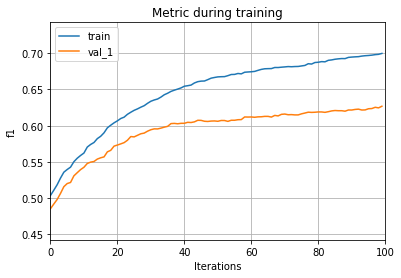

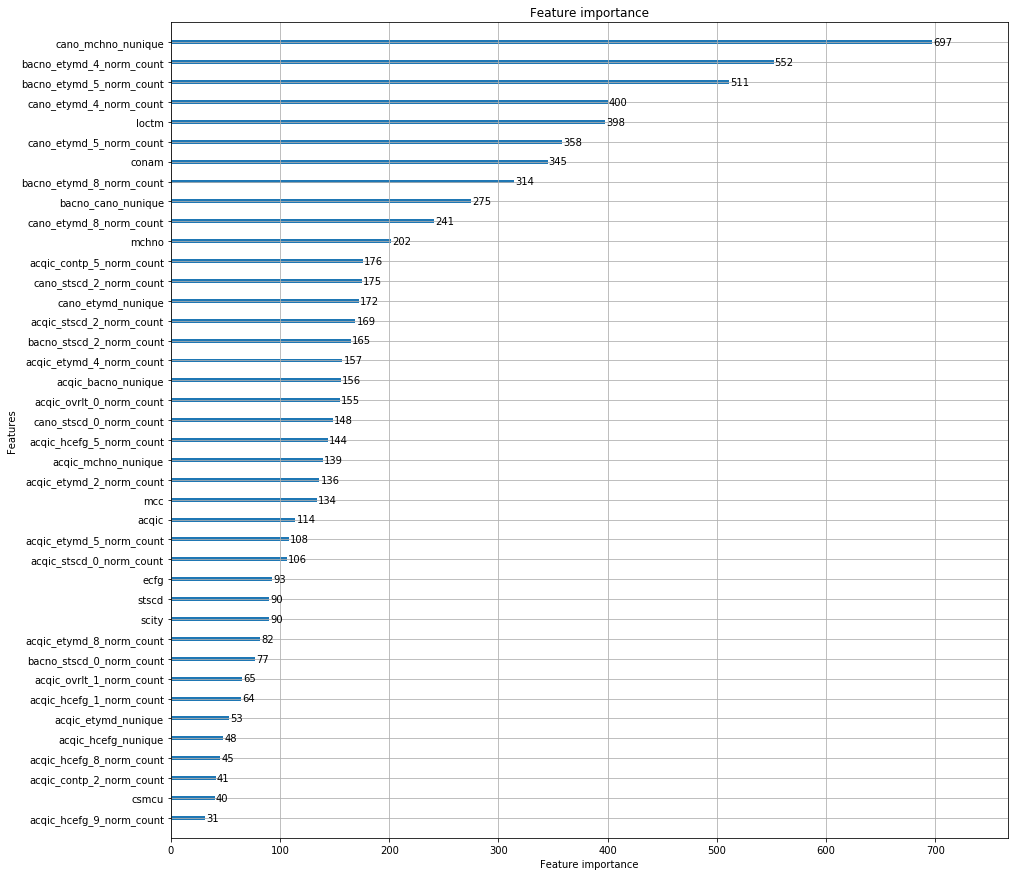

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.743151 to fit


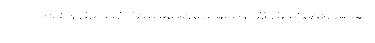

In [68]:
import lightgbm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np

# f1 score
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat)
    return 'f1', f1_score(y_true, y_hat), True

# 定義超參數  
parameters = {
    'boosting_type':'gbdt',
    'n_estimators':100,
    'objective': 'cross_entropy',
    'metric': 'cross_entropy',
    'num_iterations': 100,
    'learning_rate': 0.1,
    'max_depth': 7,
    'num_leaves': 2**7-1,
    'feature_fraction': 0.7,
    'tree_learner': 'data',
    "is_unbalance": True,
    "early_stopping_round": 30,
    #'min_child_samples':20,
    #'min_child_weight': 0.001,
}

# train data
train_data = lightgbm.Dataset(train[features],label = train[y_name],categorical_feature=cat_features)

# val_1_data
val_1_data = lightgbm.Dataset(val_1[features],label = val_1[y_name],categorical_feature=cat_features)

# model training
evals_result = {}
model = lightgbm.train(parameters,
                       train_data,
                       valid_sets = [val_1_data, train_data],
                       valid_names = ['val_1','train'], 
                       feval = lgb_f1_score,
                       evals_result = evals_result,
                       )

# plt f1 metric
try:
  lightgbm.plot_metric(evals_result, metric='f1')
  plt.show()
except:
  pass

# plt features importance
try:
  ax = lightgbm.plot_importance(model, max_num_features=40, figsize=(15,15))
  plt.show()
except:
  pass

# plt tree
try:
  ax = lightgbm.plot_tree(model,tree_index=3)
  plt.show()
except:
  pass

# plt tree_digraph
try:
  graph = lightgbm.create_tree_digraph(model,tree_index=3)
  graph.render(view=True)
except:
  pass

# val_2's F1 report

In [65]:
from sklearn.metrics import classification_report 

val_2_pred_01 = pd.Series(model.predict(val_2[features])).apply(round)

print(classification_report(val_2[y_name],val_2_pred_01,target_names=['0','1']))

AttributeError: ignored

# 產生submission

In [50]:
submission = pd.DataFrame({"txkey":test_txkey,
                           "fraud_ind":model.predict(test[features])})

# to [0,1] 
submission["fraud_ind"] = submission["fraud_ind"].apply(round)

# value_counts
print(submission["fraud_ind"].value_counts())
submission.head()

0    417343
1      4322
Name: fraud_ind, dtype: int64


,txkey,fraud_ind
1521787,592489,0
1521788,592452,0
1521789,590212,0
1521790,590209,0
1521791,592488,0


# 保存

In [0]:
submission.to_csv("./submission_30.csv")

In [52]:
print(submission["fraud_ind"].value_counts())

0    417343
1      4322
Name: fraud_ind, dtype: int64
